Generation 0: Best fitness = 4499.864549001684
Generation 1: Best fitness = 3503.918849529179
Generation 2: Best fitness = 3503.918849529179
Generation 3: Best fitness = 3352.7057846686557
Generation 4: Best fitness = 3340.200664800413
Generation 5: Best fitness = 806.1577796810981
Generation 6: Best fitness = 806.1577796810981
Generation 7: Best fitness = 544.2186194024486
Generation 8: Best fitness = 438.18365513128373
Generation 9: Best fitness = 386.1782271261629
Generation 10: Best fitness = 386.1782271261629
Generation 11: Best fitness = 363.81279358626546
Generation 12: Best fitness = 355.9831929319609
Generation 13: Best fitness = 328.7097380401083
Generation 14: Best fitness = 312.2542735241255
Generation 15: Best fitness = 312.2542735241255
Generation 16: Best fitness = 296.64578293051926
Generation 17: Best fitness = 296.64578293051926
Generation 18: Best fitness = 294.6394532509225
Generation 19: Best fitness = 294.2911140779498
Generation 20: Best fitness = 294.01219787110

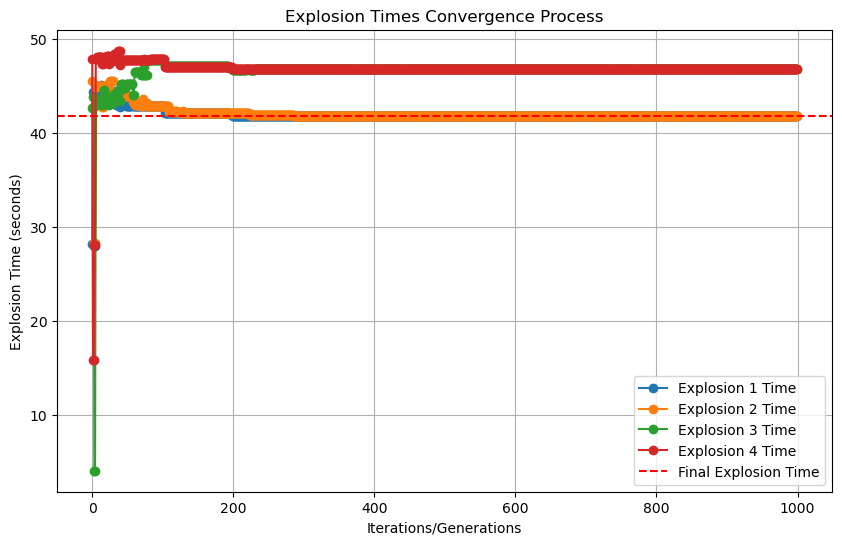

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Convert latitude and longitude to Cartesian coordinates for distance calculation
def lat_lon_to_cartesian(lon, lat, h):
    x = lon * lon_conversion
    y = lat * lat_conversion
    return np.array([x, y, h])

# Calculate the time delay from each device to a potential explosion point using absolute coordinates
def time_delay(device, explosion_point, explosion_time):
    device_cartesian = lat_lon_to_cartesian(*device)
    explosion_cartesian = lat_lon_to_cartesian(*explosion_point)
    distance = np.linalg.norm(device_cartesian - explosion_cartesian)
    time_diff = distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0
    penalty = 0

    # Check the conditions for each explosion time
    for i in range(4):
        # Ensure explosion time is greater than zero
        if explosion_times[i] <= 0:
            penalty += 1000  # Large penalty for negative or zero times
        
        # Ensure explosion time is less than the minimum arrival time for each device
        for j in range(7):
            min_arrival_time = np.min(sound_times[j])
            if explosion_times[i] >= min_arrival_time:
                penalty += 1000  # Large penalty for exceeding the minimum arrival time

    # Calculate RMSE for the sound arrival times
    for i in range(7):  # For each device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(device_locations[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - sound_times[i, j]) ** 2  # Squared error
    
    # Add penalty if the time differences between explosions exceed 5 seconds
    for i in range(4):
        for j in range(i + 1, 4):
            if abs(explosion_times[i] - explosion_times[j]) > 5:
                penalty += 1000  # Arbitrary large penalty value for violation

    return np.sqrt(total_error) + penalty  # RMSE with penalty

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/altitude
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Selection, crossover, and mutation operations with elite preservation
def evolve_population(population, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness
    population = sorted(population, key=fitness)
    
    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]
    
    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate
    
    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population)//2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)
        
        new_population.append(child)
    
    return new_population

# Genetic algorithm with elite preservation and PSO
def genetic_algorithm_with_pso(pop_size=300, generations=1000, elite_size=5):
    population = generate_initial_population(pop_size)
    history_times = []  # 用于记录每次迭代中最优解的音爆时间

    for generation in range(generations):
        population = evolve_population(population, elite_size, generation, generations)

        # Track the best solution found
        best_solution = min(population, key=fitness)
        best_fitness = fitness(best_solution)
        
        # 记录最优解的音爆时间
        explosion_times = best_solution[:4]
        history_times.append(explosion_times)
        
        print(f"Generation {generation}: Best fitness = {best_fitness}")

        # If fitness is good enough, stop early
        if best_fitness < 100:
            break
    
    return best_solution, history_times

# Run the optimized genetic algorithm with PSO
best_solution, history_times = genetic_algorithm_with_pso()

# Extract the final results
explosion_times = best_solution[:4]

# Calculate final error
total_error = fitness(best_solution)

# Output the final explosion times and positions with error
print("Best explosion times:", explosion_times)
print("Total error (RMSE):", total_error)

# 可视化残骸音爆时间收敛过程的函数
def visualize_time_convergence(history_times, final_times):
    plt.figure(figsize=(10, 6))

    # 绘制收敛过程的轨迹
    for i in range(4):
        times = [step[i] for step in history_times]
        plt.plot(times, label=f'Explosion {i+1} Time', marker='o')

    # 绘制最终的音爆时间
    plt.axhline(y=final_times[0], color='r', linestyle='--', label='Final Explosion Time')

    # 设置标签和标题
    plt.xlabel('Iterations/Generations')
    plt.ylabel('Explosion Time (seconds)')
    plt.title('Explosion Times Convergence Process')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可视化残骸音爆时间收敛过程
visualize_time_convergence(history_times, explosion_times)


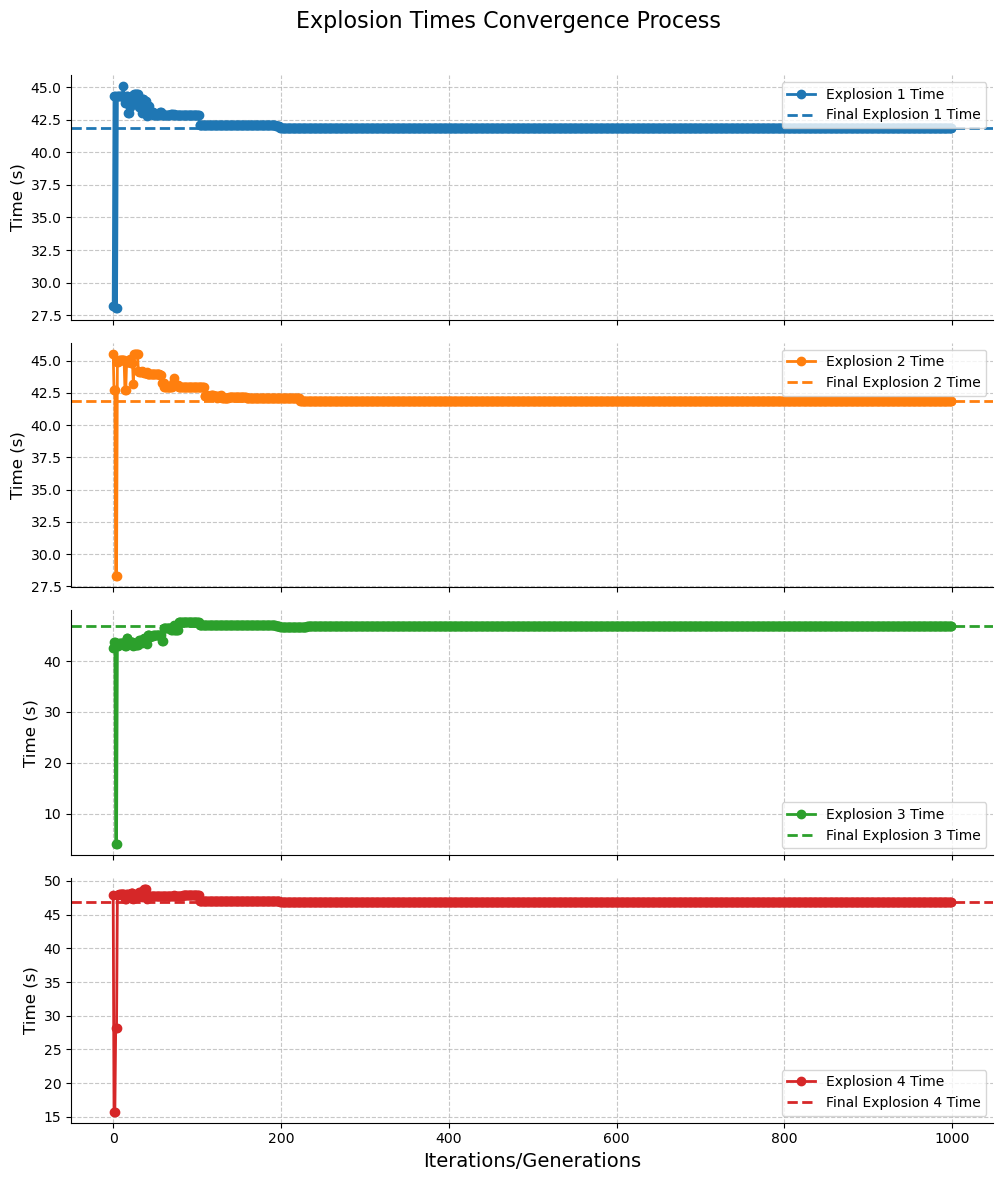

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化残骸音爆时间收敛过程的函数（每个音爆单独的子图）
def visualize_time_convergence_subplots(history_times, final_times):
    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    # 定义颜色列表，用于区分每个音爆时间的收敛轨迹
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 蓝、橙、绿、红

    for i in range(4):
        times = [step[i] for step in history_times]
        
        # 绘制每个音爆时间的收敛轨迹
        axes[i].plot(times, label=f'Explosion {i+1} Time', marker='o', linestyle='-', color=colors[i], linewidth=2)

        # 绘制最终的音爆时间
        axes[i].axhline(y=final_times[i], color=colors[i], linestyle='--', linewidth=2, label=f'Final Explosion {i+1} Time')

        # 设置 y 轴标签和图例
        axes[i].set_ylabel('Time (s)', fontsize=12)
        axes[i].legend(fontsize=10, loc='best')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # 美化边框
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

    # 设置 x 轴标签和总体标题
    axes[3].set_xlabel('Iterations/Generations', fontsize=14)
    fig.suptitle('Explosion Times Convergence Process', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# 调用函数来可视化音爆时间收敛过程
visualize_time_convergence_subplots(history_times, explosion_times)
